A few months ago, I [began experimenting with PyTorch](https://www.datahubbs.com/reinforce-with-pytorch/) and quickly made it my go-to deep learning framework. On top of that, I've had some requests to provide an intro to this framework along the lines of the general deep learning introductions I've done in the past ([here](https://www.datahubbs.com/deep-learning-101-the-theory/), [here](https://www.datahubbs.com/deep-learning-101-building-a-neural-network-from-the-ground-up/), [here](https://www.datahubbs.com/deep-learning-101-first-neural-network-tensorflow/), and [here](https://www.datahubbs.com/deep-learning-101-first-neural-network-keras/)). In that vein, let's get started with the basics of this exciting and powerful framework!

## PyTorch Primer

Like it's main rival TensorFlow, PyTorch has some big, industrial backing behind it. It grew out of [Facebook's AI lab](https://venturebeat.com/2017/11/29/tech-giants-are-using-open-source-frameworks-to-dominate-the-ai-community/) and is due for it's [version 1.0 release sometime this year](https://techcrunch.com/2018/05/02/facebook-announces-pytorch-1-0-a-more-unified-ai-framework/). It boasts pythonic syntax inspired by popular libraries like Numpy and dynamic graphs. The pythonic style makes quick and easy to write with less boilerplate code and the dynamic graphs help make development - particularly in an IDE like Spyder or Jupyter - seem more natural. While it's still not as popular as TensorFlow, it is gaining steam and is being picked up by organizations like [Fast.ai](https://www.fast.ai/) as their framework of choice.

So, all of that is great, but I'm sure you're here to learn a bit about how to use it, right?

To keep things simple and straightforward, and so you can compare the syntax used here to my previous tutorials, we'll stick with the `make_moons` classification data from `sklearn`. Go ahead and import the following packages, and if you haven't yet, hop on over to [pytorch.org](https://pytorch.org/) to get PyTorch installed on your machine.

In [1]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
%matplotlib inline
print("Using PyTorch Version %s" %torch.__version__)

Using PyTorch Version 0.4.1.post2


With everything imported successfully, let's generate our data.

In [2]:
np.random.seed(0)
torch.manual_seed(0)
X, Y = make_moons(500, noise=0.2)

# Split into test and training data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
    test_size=0.25, random_state=73)

This is a pretty straightforward data set that has two crescent moon-shaped groups that we try to classify. It's good for a problem like this because in this 2D space, the classification boundary is non-linear meaning that linear discriminators can't classify this properly. However, neural networks are non-linear function approximators so they in fact can deal with this, as we'll soon see.

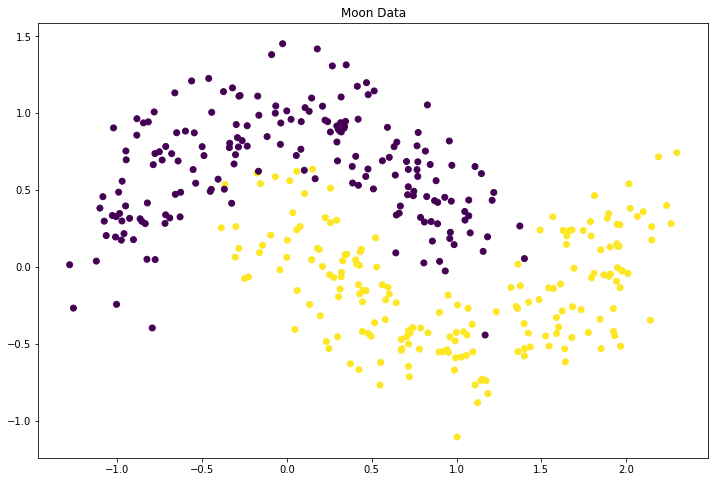

In [10]:
plt.figure(figsize=(12,8))
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train)
plt.title('Moon Data')
plt.show()

## Build our Neural Network

PyTorch networks are really quick and easy to build, just set up the inputs and outputs as needed, then stack your linear layers together with a non-linear activation function in between. At the end of it, you'll be able to simply print your network for visual inspection. 

We don't need a very large network for this classification task, so we'll keep it small and clean.

In [6]:
# Define network dimensions
n_input_dim = X_train.shape[1]
# Layer size
n_hidden = 4 # Number of hidden nodes
n_output = 1 # Number of output nodes = for binary classifier

# Build your network
net = nn.Sequential(
    nn.Linear(n_input_dim, n_hidden),
    nn.ELU(),
    nn.Linear(n_hidden, n_output),
    nn.Sigmoid())
    
print(net)

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=4, out_features=1, bias=True)
  (3): Sigmoid()
)


There we have it! Just a few lines of code and we have a neural network for binary classification. We still have a few steps to set up before we get around to training it, but I want to point out that the network itself takes inputs to produce a given output, there are no special methods that need to be called or any other steps in order to complete a forward pass. For example:

In [6]:
x = torch.FloatTensor([1, 1])
net(x)

tensor([0.5764], grad_fn=<SigmoidBackward>)

Here, we just define a `FloatTensor` in PyTorch, and pass the values to get a prediction. In addition, we can run this on a GPU if we have CUDA installed with a rather simple adjustment.

In [7]:
net.cuda()
x = torch.FloatTensor([1, 1]).to(device='cuda')
net(x)

tensor([0.5764], device='cuda:0', grad_fn=<SigmoidBackward>)

Note that we have to tell the network to use the GPU by calling the `cuda` method, then define the `device` for our tensor. This is my preferred method of setting the device, but PyTorch is very flexible and allows [numerous other ways for using your GPU](https://github.com/pytorch/pytorch/issues/1668).

Now let's go back to getting our network ready to train by defining the loss function and optimizer.

In [7]:
loss_func = nn.BCELoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

For this, all that is needed is the **binary cross entropy loss** (`BCELoss`) function, and to set our optimizer and its learning rate. Thanks to the wonders of [**auto differentiation**](https://en.wikipedia.org/wiki/Automatic_differentiation), we can let PyTorch handle all of the derivatives and messy details of backpropagation making our training seamless and straightforward.

## Training a PyTorch Classifier

To train our network, we just need to loop over our data set a few hundred times until we reach convergence. Typically, you'd break training up into mini-batches, but this data set is small enough that we can simply pass the whole thing through, make our predictions, calculate the loss, and update the network all in one pass. 

As shown above, PyTorch doesn't take Numpy arrays directly, so we'll need to pass those values through the `torch.FloatTensor` function first to convert it to the proper format, which I've denoted with an underscore *t* (`_t`) for clarity. If you want to run this on your GPU, just add `.to(device='cuda')` to the end of each of these commands and send the network to the GPU as done above too (this network is small enough that you likely will get better performance out of your CPU, but it's good to know that you've got options). 

Once we've made our predictions and calculated our loss, we need to call the `.backward()` method on the `loss` tensor itself. This tells PyTorch to calculate all of the gradients for our network. After that, we tell the optimizer to `.step()` forward, which applies those gradients to all of the weights and biases in the network, causing it to learn the data better. After that, we can zero out all of the gradients, essentially throwing them away so that we can apply the new gradients after the next iteration.

To log our data, you'll notice we call the `.detach()` method on our predictions, `y_hat`. We do this to tell PyTorch to remove the graph structure from this value meaning that we no longer want to calculate derivatives with these values. It's very important to keep track of what are variables with gradients and which ones aren't, particularly if you have multiple networks working together. Here, we also convert the tensor to a Numpy array for additional flexibility. For this problem, this last step isn't strictly necessary, but I included it for illustration.

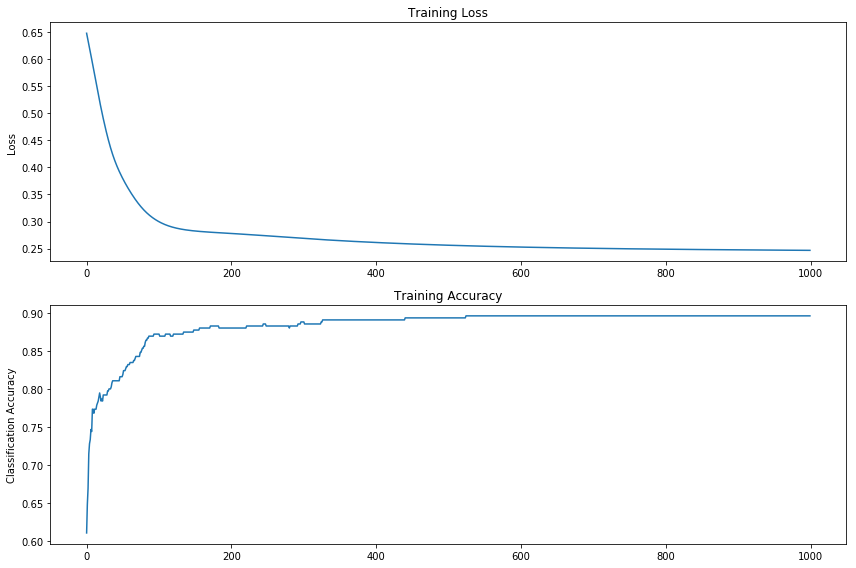

In [8]:
train_loss = []
train_accuracy = []
iters = 1000
Y_train_t = torch.FloatTensor(Y_train).reshape(-1, 1)
for i in range(iters):
    X_train_t = torch.FloatTensor(X_train)
    y_hat = net(X_train_t)
    loss = loss_func(y_hat, Y_train_t)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    y_hat_class = np.where(y_hat.detach().numpy()<0.5, 0, 1)
    accuracy = np.sum(Y_train.reshape(-1,1)==y_hat_class) / len(Y_train)
    train_accuracy.append(accuracy)
    train_loss.append(loss.item())
    
fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(train_loss)
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')

ax[1].plot(train_accuracy)
ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Training Accuracy')

plt.tight_layout()
plt.show()

It worked! Our network trained over the 1,000 iterations and pushed its classification accuracy towards 90%. Let's go ahead and visualize this to see how well it fares on our test set.

Test Accuracy 0.87


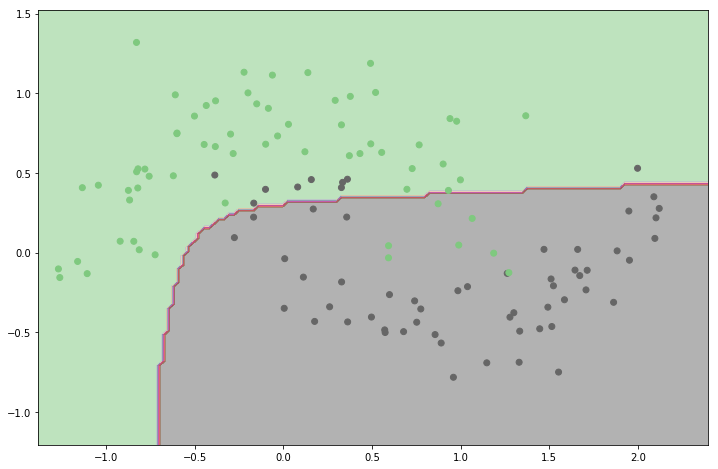

In [7]:
# Pass test data
X_test_t = torch.FloatTensor(X_test)
y_hat_test = net(X_test_t)
y_hat_test_class = np.where(y_hat_test.detach().numpy()<0.5, 0, 1)
test_accuracy = np.sum(Y_test.reshape(-1,1)==y_hat_test_class) / len(Y_test)
print("Test Accuracy {:.2f}".format(test_accuracy))

# Plot the decision boundary
# Determine grid range in x and y directions
x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1

# Set grid spacing parameter
spacing = min(x_max - x_min, y_max - y_min) / 100

# Create grid
XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
               np.arange(y_min, y_max, spacing))

# Concatenate data to match input
data = np.hstack((XX.ravel().reshape(-1,1), 
                  YY.ravel().reshape(-1,1)))

# Pass data to predict method
data_t = torch.FloatTensor(data)
db_prob = net(data_t)

clf = np.where(db_prob<0.5,0,1)

Z = clf.reshape(XX.shape)

plt.figure(figsize=(12,8))
plt.contourf(XX, YY, Z, cmap=plt.cm.Accent, alpha=0.5)
plt.scatter(X_test[:,0], X_test[:,1], c=Y_test, 
            cmap=plt.cm.Accent)
plt.show()

87% accuracy isn't too shabby for such a small network, but we can do better by tuning the hyperparameters a bit. In this case, we'll tweak the number of hidden nodes to see if we get better results.

## Improving our Accuracy

We'll implement an object oriented approach to building and training these networks which will make it much, much easier for us to adjust when we need to. Also, note that to run this on a GPU, all you need to do is set the device argument to `cuda` and you should be able to have it run without a problem there.

In [24]:
class network():
    
    def __init__(self, X, Y, n_hidden=4, learning_rate=1e-2, device='cpu'):
        self.device = device
        self.X = X
        self.Y = Y.reshape(-1,1)
        self.Y_t = torch.FloatTensor(self.Y).to(device=self.device)
        self.n_input_dim = X.shape[1]
        self.n_output = 1
        self.learning_rate = learning_rate
        self.n_hidden = n_hidden
        
        # Build network
        self.net = nn.Sequential(
            nn.Linear(self.n_input_dim, self.n_hidden), 
            nn.ELU(),
            nn.Linear(self.n_hidden, self.n_output),
            nn.Sigmoid())
        
        if self.device == 'cuda':
            self.net.cuda()
        
        self.loss_func = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.net.parameters(), 
                                          lr=self.learning_rate)
        
    def predict(self, X):
        # Function to generate predictions based on data
        X_t = torch.FloatTensor(X).to(device=self.device)
        return self.net(X_t)
    
    def calculate_loss(self, y_hat):
        return self.loss_func(y_hat, self.Y_t)
    
    def update_network(self, y_hat):
        self.optimizer.zero_grad()
        loss = self.calculate_loss(y_hat)
        loss.backward()
        self.optimizer.step()
        self.training_loss.append(loss.item())
        
    def calculate_accuracy(self, y_hat_class, Y):
        return np.sum(Y.reshape(-1,1)==y_hat_class) / len(Y)
        
    def train(self, n_iters=1000):
        self.training_loss = []
        self.training_accuracy = []
        
        for i in range(n_iters):
            y_hat = self.predict(X)
            self.update_network(y_hat)
            y_hat_class = np.where(y_hat<0.5, 0, 1)
            accuracy = self.calculate_accuracy(y_hat_class, self.Y)
            self.training_accuracy.append(accuracy)
            
    def plot_training_results(self):
        fig, ax = plt.subplots(2, 1, figsize=(12,8))
        ax[0].plot(self.training_loss)
        ax[0].set_ylabel('Loss')
        ax[0].set_title('Training Loss')

        ax[1].plot(self.training_accuracy)
        ax[1].set_ylabel('Classification Accuracy')
        ax[1].set_title('Training Accuracy')

        plt.tight_layout()
        plt.show()
        
    def plot_testing_results(self, X_test, Y_test):
        # Pass test data
        y_hat_test = self.predict(X_test)
        y_hat_test_class = np.where(y_hat_test<0.5, 0, 1)
        print("Test Accuracy {:.2f}%".format(
            self.calculate_accuracy(y_hat_test_class, Y_test) * 100))

        # Plot the decision boundary
        # Determine grid range in x and y directions
        x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
        y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1

        # Set grid spacing parameter
        spacing = min(x_max - x_min, y_max - y_min) / 100

        # Create grid
        XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
                       np.arange(y_min, y_max, spacing))

        # Concatenate data to match input
        data = np.hstack((XX.ravel().reshape(-1,1), 
                          YY.ravel().reshape(-1,1)))

        # Pass data to predict method
        db_prob = self.predict(data)

        clf = np.where(db_prob<0.5,0,1)

        Z = clf.reshape(XX.shape)

        plt.figure(figsize=(12,8))
        plt.contourf(XX, YY, Z, cmap=plt.cm.Accent, alpha=0.5)
        plt.scatter(X_test[:,0], X_test[:,1], c=Y_test, 
                    cmap=plt.cm.Accent)
        plt.show()

Just to ensure that this works, let's run it with the default settings to show that the results match what we saw above.

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=4, out_features=1, bias=True)
  (3): Sigmoid()
)


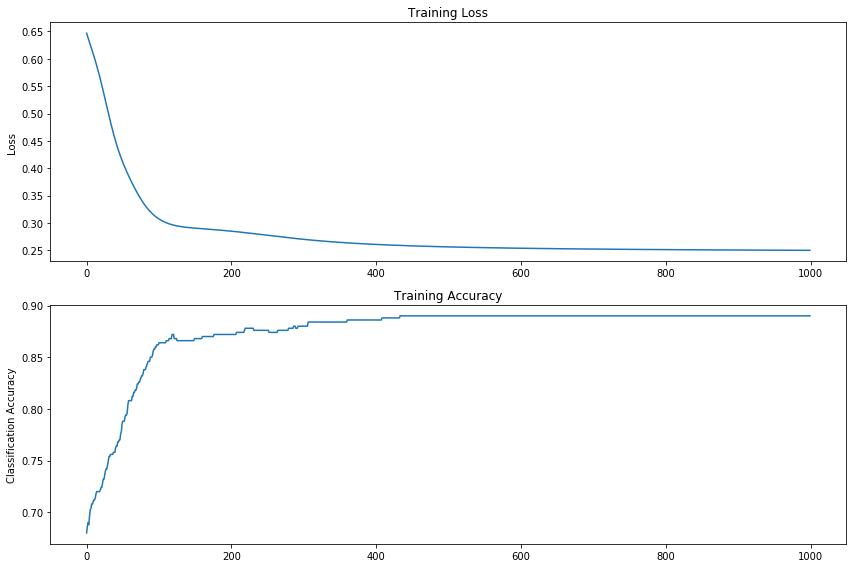

Test Accuracy 87.20%


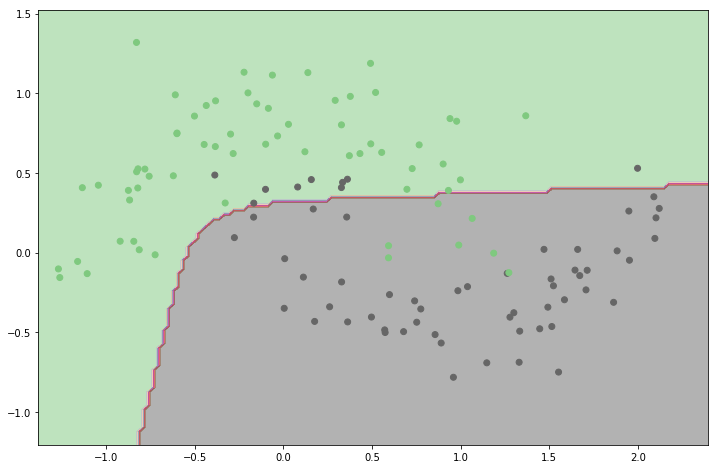

In [25]:
net = network(X, Y)
print(net.net)
net.train()
net.plot_training_results()
net.plot_testing_results(X_test, Y_test)

There's some variation thanks to the initialization, but by and large, it is very close to what we saw above. Let's run this in a loop and see how adjusting the hidden nodes changes our results.

Number of hidden nodes: 1
Test Accuracy 84.80%


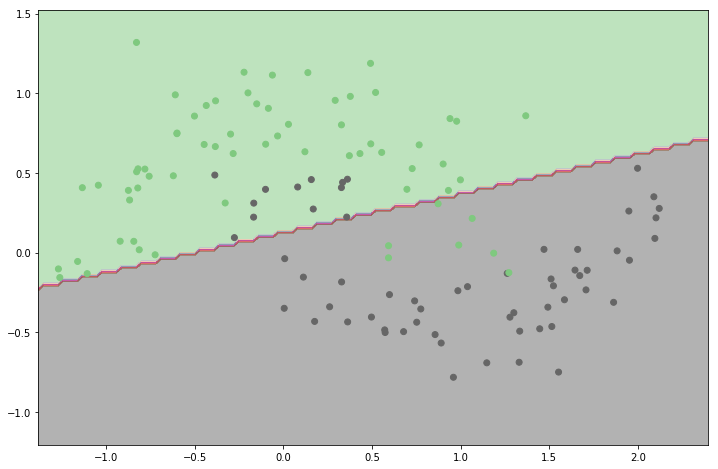

Number of hidden nodes: 5
Test Accuracy 84.80%


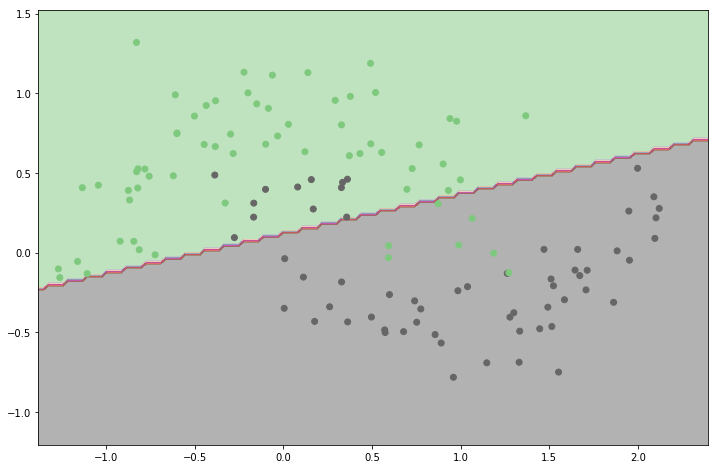

Number of hidden nodes: 10
Test Accuracy 95.20%


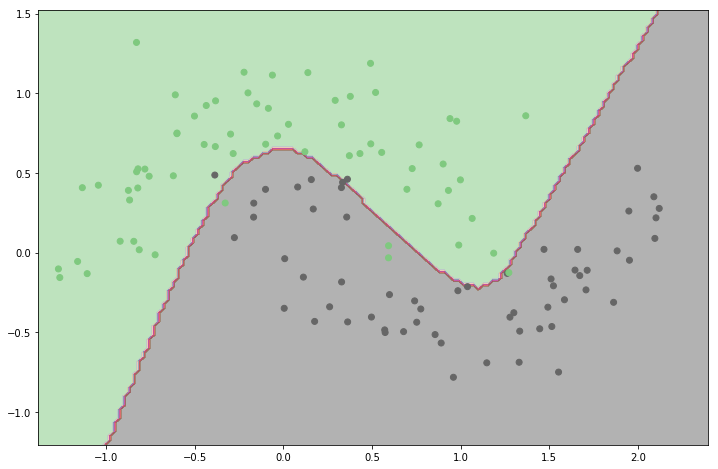

Number of hidden nodes: 25
Test Accuracy 96.00%


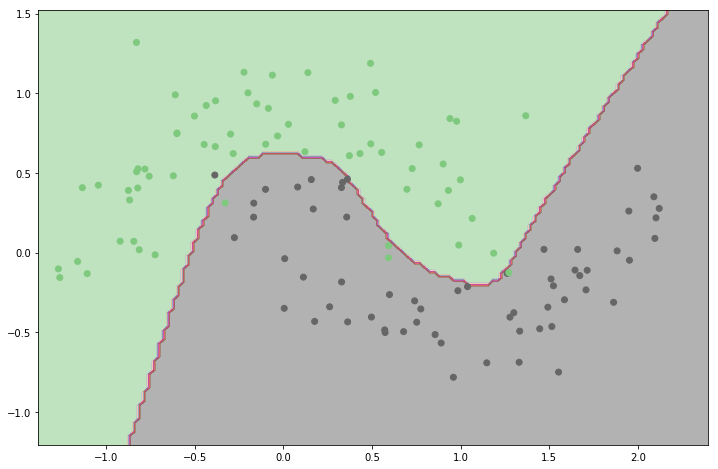

Number of hidden nodes: 50
Test Accuracy 96.00%


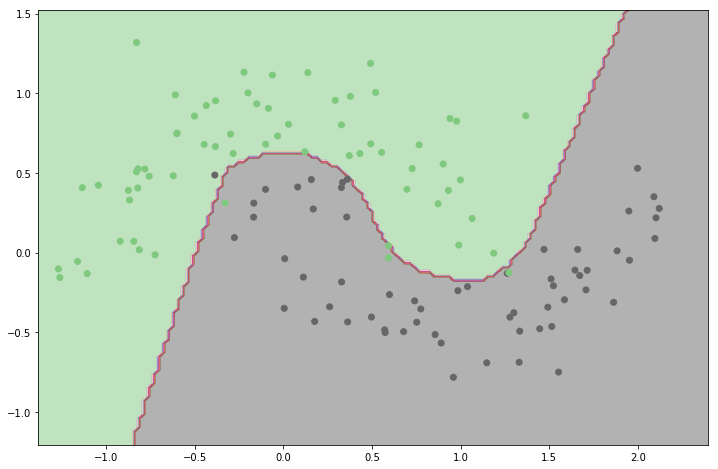

In [29]:
n_hidden_nodes = [1, 5, 10, 25, 50]

for n in n_hidden_nodes:
    print("Number of hidden nodes: {:d}".format(n))
    net = network(X, Y, n_hidden=n)
    net.train()
    net.plot_testing_results(X_test, Y_test)

The network shows that it is able to learn a reasonable decision boundary between the data sets. We get better and better results as we increase the number of hidden nodes in our network, although we do run the risk of over fitting. It would be instructive to see how the depth of the network can change the results we see here for the better and also to try to apply these same techniques to some more interesting classification problems. There are a wealth of interesting problems that can be attacked with these machine learning techniques and I encourage you to grab some data and see what you can come up with! 

If this was helpful for you, let me know, I love to get feedback on these tutorials. 